### 1. setting and data

In [5]:
#install module
!pip install --upgrade pip
!pip install pyyaml pandas numpy matplotlib seaborn scikit-learn
!pip uninstall keras -y
!pip install "tensorflow-macos>=2.16"
!pip install opencv-python

Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)


In [6]:
import sys, os

# 현재 실행 중인 노트북 기준 루트 디렉토리 잡기 (notebook과 config 폴더가 같은 상위 폴더에 있어야 함)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [7]:
#import module
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from config.load_config import load_config
from data.split_dataset import data_count, extract_balanced_dataset
from data.data_distribution import class_distribution
from data.dataloader import get_generators
from models.build_model import get_model
from models.build_model import build_model
from train.optimizer import get_optimizer
from train.callbacks import get_callbacks
from train.trainer import train_model
from utils.evaluation import evaluate_model
from utils.evaluation import plot_confusion_matrix
from utils.evaluation import plot_train_history
from utils.evaluation import show_top_misclassified
from utils.evaluation import plot_metrics_text
from utils.save_results import save_results


### change the config path

In [8]:
# Load configuration
config = load_config('/Users/vnlt/PROJECT/ex-cnn-cv/config/config.yaml')
data_dir = f"{config['base_output_dir']}/seed{config['seed']}"
batch_size = config['batch_size']
save_dir = f"results/{config['experiment_id']}"
os.makedirs(save_dir, exist_ok=True)


In [9]:
# check if config is loaded correctly
print(type(config))
print(config)


<class 'dict'>
{'experiment_id': 'EfficientNetB0_v1_test2', 'backbone_name': 'EfficientNetB0', 'original_dataset_dir': '/Volumes/PortableSSD/dataset-pepper', 'base_output_dir': '/Users/vnlt/PROJECT/ex-cnn-cv/data/dataset', 'input_shape': [224, 224, 3], 'train_ratio': 0.7, 'val_ratio': 0.2, 'test_ratio': 0.1, 'seed': 99, 'augmentations': None, 'epochs': 1, 'batch_size': 5, 'optimizer': 'adamw', 'learning_rate': 0.0001, 'weight_decay': '1e-5', 'patience': 10, 'dropout_rate': 0.5, 'save_best_only': True, 'model_save_dir': '/Users/vnlt/PROJECT/ex-cnn-cv/models/save_models', 'num_classes': 5}


In [10]:
# import and define preprocess_map for specific data generators to use
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from sklearn.model_selection import train_test_split


preprocess_map = {
    'MobileNetV2': mobilenet_preprocess,
    'EfficientNetB0': efficientnet_preprocess,
    'ResNet50': resnet_preprocess,
    'DenseNet121': densenet_preprocess,
}

### checkpoint-split dataset
- select data split O/X
- select data generator for ex-ver

In [ ]:
class_image_counts, images, min_count = data_count(
    original_dataset_dir=config['original_dataset_dir']
)

extract_balanced_dataset(
    original_dataset_dir=config['original_dataset_dir'],
    min_count=min_count,
    base_output_dir=f"{config['base_output_dir']}/seed{config['seed']}",
    seed=config['seed']
)

#### data generators for verA, B, C

In [11]:
# data generators - preprocessing and augmentation for A, B, C(except Full)
train_gen, val_gen, test_gen = get_generators(
    model_name=config['backbone_name'],
    input_shape=tuple(config['input_shape']),
    batch_size=config['batch_size'],
    data_dir=f"{config['base_output_dir']}/seed{config['seed']}",
    train_ratio=config['train_ratio'],
    val_ratio=config['val_ratio'],
    test_ratio=config['test_ratio'],
    seed=config['seed'],
    augmentations=None,
)

<function get_generators.<locals>.custom_preprocessing at 0x31e73f790>
<function preprocess_input at 0x31ceb9940>
Found 70 validated image filenames belonging to 5 classes.
Found 20 validated image filenames belonging to 5 classes.
Found 11 validated image filenames belonging to 5 classes.


#### data generators for verC-full

In [ ]:
#data generators for ver_C_full
import glob

def get_generators_non_seed(model_name, input_shape=(224, 224, 3), batch_size=None, data_dir=None,train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=None, augmentations=None):
    if data_dir is None:
        raise ValueError("❌ data_dir 값을 지정해야 합니다.")
    if augmentations is None:
        augmentations = []

    preprocess_func = preprocess_map[model_name]

    # 이미지 경로 및 라벨 수집
    image_paths = []
    labels = []
    class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    for class_name in class_dirs:
        class_path = os.path.join(data_dir, class_name)
        image_files = glob.glob(os.path.join(class_path, '*'))  # 모든 확장자 허용
        image_paths.extend(image_files)
        labels.extend([class_name] * len(image_files))

    df = pd.DataFrame({
        'filename': image_paths,
        'class': labels
    })
    
    # 클래스별 stratified split
    train_df, temp_df = train_test_split(df, stratify=df['class'], train_size=train_ratio, random_state=seed)
    val_df, test_df = train_test_split(
        temp_df,
        stratify=temp_df['class'],
        test_size=test_ratio / (val_ratio + test_ratio),
        random_state=seed
    )
    
    # generator setup
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_func,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
    )
    
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    
    print(preprocess_func)
    
    # generator 생성
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
    )

    val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
    )

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filename',
        y_col='class',
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
    )

    return train_gen, val_gen, test_gen

train_gen, val_gen, test_gen = get_generators_non_seed(
    model_name=config['backbone_name'],
    input_shape=tuple(config['input_shape']),
    batch_size=config['batch_size'],
    data_dir="/Users/vnlt/PROJECT/ex-cnn-cv/data/dataset/seed99", # f"{config['original_dataset_dir']}",
    train_ratio=config['train_ratio'],
    val_ratio=config['val_ratio'],
    test_ratio=config['test_ratio'],
    seed=config['seed'],
    augmentations=config['augmentations']
)

#### data generators for verD

In [ ]:
#data generators for ver_D

def get_generators(model_name, input_shape=(224, 224, 3), batch_size=None, data_dir=None,train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=None, augmentations=None):
    if data_dir is None:
        raise ValueError("❌ data_dir 값을 지정해야 합니다.")
    if augmentations is None:
        augmentations = []

    preprocess_func = preprocess_map[model_name]
    
    # 이미지 경로 및 라벨 수집
    image_paths = []
    labels = []
    
    for cls in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        image_files = glob.glob(os.path.join(cls_path, '*'))  # 모든 확장자 허용
        image_paths.extend(image_files)
        labels.extend([cls] * len(image_files))

    df = pd.DataFrame({'filename': image_paths, 'class': labels})
    
    # 클래스별 stratified split
    train_df, temp_df = train_test_split(df, stratify=df['class'], train_size=train_ratio, random_state=seed)
    val_df, test_df = train_test_split(
        temp_df,
        stratify=temp_df['class'],
        test_size=test_ratio / (val_ratio + test_ratio),
        random_state=seed
    )
    
    # generator setup
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_func,
        rotation_range=config['rotation_range'],
        width_shift_range=config['width_shift_range'],
        height_shift_range=config['height_shift_range'],
        zoom_range=config['zoom_range'],
        horizontal_flip=config['horizontal_flip'],
        vertical_flip=config['vertical_flip'],
    )
    
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    
    print(preprocess_func)
    
    # generator 생성
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        directory=None
    )

    val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        directory=None  
    )

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filename',
        y_col='class',
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        directory=None
    )

    return train_gen, val_gen, test_gen

train_gen, val_gen, test_gen = get_generators(
    model_name=config['backbone_name'],
    input_shape=tuple(config['input_shape']),
    batch_size=config['batch_size'],
    data_dir=f"{config['base_output_dir']}/seed{config['seed']}",
    train_ratio=config['train_ratio'],
    val_ratio=config['val_ratio'],
    test_ratio=config['test_ratio'],
    seed=config['seed'],
    augmentations=config['augmentations']
)

### check data import

EfficientNetB0_v1_test2_dataset_distribution


,Train,Validation,Test
Class,,,
Bacterial-spot,14,4,2
Healthy,14,4,2
PMMoV,14,4,2
Powdery-mildew,14,4,2
TSWV,14,4,3


Saved class distribution table to 'results/EfficientNetB0_v1_test2/dist_table.png'


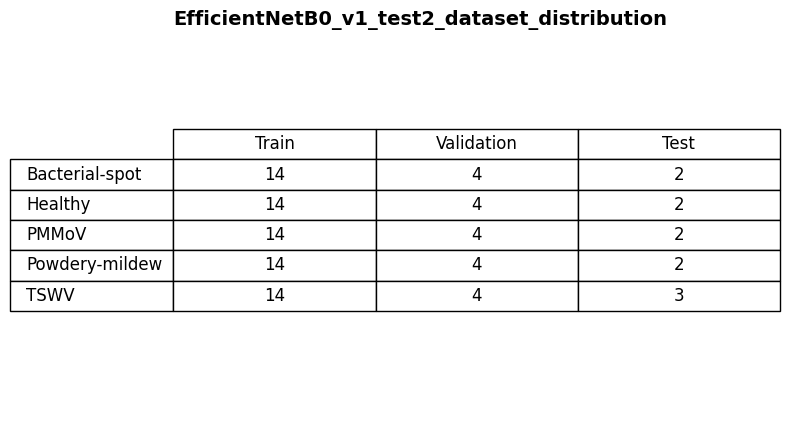

In [12]:
class_distribution(
    train_gen,
    val_gen,
    test_gen,
    config,
    save_path=f"{save_dir}/dist_table.png"
)

### 2. model training

In [13]:
# model structure
model = build_model(
    backbone_name=config['backbone_name'],
    input_shape=tuple(config['input_shape']),
    num_classes=config['num_classes'],
    dropout_rate=config['dropout_rate']
)
# compile model
optimizer = get_optimizer(
    optimizer_name=config['optimizer'],
    learning_rate=config['learning_rate'],
    weight_decay=config.get('weight_decay', 0.0)
)

callbacks = get_callbacks(
    model_name=config['backbone_name'],
    save_dir=f"results/{config['experiment_id']}",
    patience=config['patience']
)

In [ ]:
# model training
history = train_model(
    model,
    train_gen,
    val_gen,
    epochs=config['epochs'],
    callbacks=callbacks,
    optimizer=optimizer
)

### 3. evaluation and results

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
y_true, y_pred, y_prob = evaluate_model(model, test_gen)


In [ ]:
# Check class indices
print("Original class_indices (class name → index):")
print(test_gen.class_indices)

In [ ]:
class_names = list(test_gen.class_indices.keys())

In [ ]:
# results visualization
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)

metrics_dict = {
    "accuracy": report["accuracy"],
    "precision": report["macro avg"]["precision"],
    "recall": report["macro avg"]["recall"],
    "f1_score": report["macro avg"]["f1-score"]
}

plot_metrics_text(
    metrics_dict=metrics_dict,
    experiment_id=config['experiment_id'],
    save_path=f"{save_dir}/metrics_text.png"
)

plot_confusion_matrix(
    cm, 
    class_names, 
    title="Confusion Matrix", 
    save_path=f"{save_dir}/confusion_matrix.png"
)
plot_train_history(
    history,
    save_path=f"{save_dir}/history_graph.png"
)

show_top_misclassified(
    y_true,
    y_pred,
    y_prob,
    class_names,
    generator=test_gen,
    model_name=config['experiment_id'],
    save_dir=save_dir,
    top_n=3
)

### 4. results save

In [ ]:

save_results(
    model_name=config['backbone_name'],
    history=history,
    cm=confusion_matrix(y_true, y_pred),
    class_names=list(test_gen.class_indices.keys()),
    report=classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()), output_dict=True),
    save_dir= save_dir
)

print(f"\u2705 저장 완료: {save_dir}")
